## Background

You will use the data contained in the train.csv file to train a model that will predict **dissolved inorganic carbon (DIC)** content in the water samples.

In [31]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set seed
np.random.seed(123)


In [3]:
# Import data
train_df = pd.read_csv('data/train.csv')
train_df.columns = train_df.columns.str.lower().str.replace(' ', '_')

# Data exploration
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1454 non-null   int64  
 1   lat_dec            1454 non-null   float64
 2   lon_dec            1454 non-null   float64
 3   no2um              1454 non-null   float64
 4   no3um              1454 non-null   float64
 5   nh3um              1454 non-null   float64
 6   r_temp             1454 non-null   float64
 7   r_depth            1454 non-null   int64  
 8   r_sal              1454 non-null   float64
 9   r_dynht            1454 non-null   float64
 10  r_nuts             1454 non-null   float64
 11  r_oxy_micromol.kg  1454 non-null   float64
 12  unnamed:_12        0 non-null      float64
 13  po4um              1454 non-null   float64
 14  sio3um             1454 non-null   float64
 15  ta1.x              1454 non-null   float64
 16  salinity1          1454 

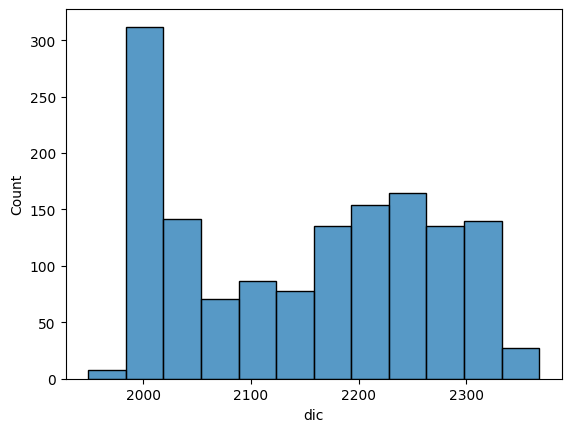

In [4]:
# Check distribution of outcome variable
sns.histplot(train_df['dic'], kde=False)
plt.show()


## Preprocess

In [5]:
# Remove 'id' and 'unnamed:_12' columns (for reasons specified above)
train_df = train_df.drop(['id', 'unnamed:_12'], axis=1)

## Build & train model

In [ ]:
def create_model(optimizer='adam', learn_rate=0.001, momentum=0.0,
                 activation='relu', l1_reg=0.01, l2_reg=0.01,
                 dropout_rate=0.0, neurons_layer1=64, neurons_layer2=64):
    # Assuming train_df is available to compute the normalization layer statistics
    normalizer = Normalization(axis=-1)
    normalizer.adapt(train_df.drop('dic', axis=1).to_numpy())
    
    model = Sequential([
        normalizer,  # Normalization layer
        Dense(neurons_layer1, input_dim=train_df.shape[1] - 1, activation=activation,
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation=activation,
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
        Dropout(dropout_rate),
        Dense(1, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))  # Output layer
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learn_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learn_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learn_rate, momentum=momentum)
    else:
        opt = Adam(learning_rate=learn_rate)
    
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Update model wrapper
model = KerasRegressor(model=create_model, verbose=0)

# Update param_grid with new hyperparameters
param_grid = {
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],
    'model__learn_rate': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    'model__momentum': [0.0, 0.8, 0.85, 0.9, 0.95, 0.99],
    'model__activation': ['relu', 'tanh', 'sigmoid', 'linear', 'elu', 'selu'],
    'model__l1_reg': [0.0001, 0.001, 0.01, 0.1],
    'model__l2_reg': [0.0001, 0.001, 0.01, 0.1],
    'model__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__neurons_layer1': [32, 64, 128],
    'model__neurons_layer2': [32, 64, 128],
    'batch_size': [5, 10, 15, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_df.drop('dic', axis=1), train_df['dic'], epochs = 100)


2024-03-20 03:14:38.239973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 03:14:38.259060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 03:14:38.274664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(train_df.drop('dic', axis=1), train_df['dic'])

In [27]:
# Retrieve the index of the best model
best_index = grid_result.best_index_

# Extract the mean and standard deviation of the MSE for the best model
mean_mse = grid_result.cv_results_['mean_test_score'][best_index]
std_mse = grid_result.cv_results_['std_test_score'][best_index]

# Print the results
print(f"Mean MSE for the best model during CV: {mean_mse}")
print(f"Standard deviation of MSE for the best model during CV: {std_mse}")

Mean MSE for the best model during CV: 0.9939761986615961
Standard deviation of MSE for the best model during CV: 0.0007815939085542652


In [ ]:
from keras.callbacks import EarlyStopping

# Define your model creation function as before
def create_model(...):
    # model definition
    return model

# After determining the best hyperparameters, set up your model
model = KerasRegressor(model=create_model, verbose=0, optimizer='best_optimizer', learn_rate='best_learn_rate', ...)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(train_df.drop('dic', axis=1), train_df['dic'], validation_split=0.2, epochs=100, callbacks=[early_stopping])


## Predict testing data

In [13]:
# Import data
test_df = pd.read_csv('data/test.csv')
test_df.columns = train_df.columns.str.lower().str.replace(' ', '_')

# define feature matrix
X_test = test_df.drop('dic', axis=1).values

# define target vector
y_test = test_df['dic'].values

In [28]:

# Step 1: Retrieve the best model from grid search
best_model = grid_result.best_estimator_

# Step 2: Prepare test dataset (Make sure it's prepared in the same way as your training data)
# If you've applied any transformations to your training dataset, apply the same here
X_test = test_df.drop('dic', axis=1, errors='ignore')  # Assuming 'dic' might not be in your test dataset

# Step 3: Use the best model to make predictions on the test dataset
predictions = history.predict(X_test)

In [29]:
# Import data
submission_df = pd.read_csv('data/sample_submission.csv')
submission_df.columns = submission_df.columns.str.lower().str.replace(' ', '_')

# Assuming 'predictions' is your vector of predicted values
submission_df['dic'] = predictions

submission_df

,id,dic
0,1455,968.812805
1,1456,937.844543
2,1457,895.563660
3,1458,1106.186890
4,1459,981.565491
...,...,...
480,1935,1352.263794
481,1936,1269.381470
482,1937,1217.425415
483,1938,1366.855957


In [30]:
submission_df.to_csv('linus_submission4.csv', index=False)